# Importing Necessary Libraries

In [19]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Data Processing of Dataset 1

In [20]:
cyber1 = pd.read_csv("D:\cybergaurd\improv\cb_multi_labeled_balanced.csv")
cyber1

,text,label
0,@ZubearSays Any real nigga isn't letting this ...,ethnicity/race
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,not_cyberbullying
2,"the only thing i wish, i wish a nigga would",ethnicity/race
3,You saudias are not friends of Muslim idiots c...,religion
4,@JaydenT2399 @TractorLaw @holmes_gael @erconge...,religion
...,...,...
99985,Thank fuck they didn’t dance remix Peru #LoveI...,not_cyberbullying
99986,Sierra Canyon vs. Alemany - California High Sc...,not_cyberbullying
99987,@queenbellaxoxo @PontiacMadeDDG @HalleBailey B...,gender/sexual
99988,What you like yo nigga to call you,ethnicity/race


In [21]:
cyber1['label'].value_counts()

label
not_cyberbullying    50000
ethnicity/race       17000
gender/sexual        17000
religion             15990
Name: count, dtype: int64

In [22]:
cyber1.drop_duplicates(subset = ['text'], inplace = True)
cyber1.duplicated().sum()

0

# Data Processing of Dataset 2

In [23]:
cyber2 = pd.read_csv("D:\cybergaurd\improv\cyberbullying_tweets.csv")
cyber2.rename(columns = {'tweet_text' : 'text', 'cyberbullying_type' : 'label'}, inplace = True)
cyber2

,text,label
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [24]:
cyber2['label'].value_counts()

label
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [25]:
cyber2.drop_duplicates(subset = ['text'], inplace = True)
cyber2.duplicated().sum()

0

# Splitting Data

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming cyber1 is your DataFrame with columns 'text' and 'label'
texts = cyber1['text']
labels = cyber1['label']

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
label_mapping = {original_label: int_label for original_label, int_label in zip(cyber1['label'], encoded_labels)}
print(label_mapping)
# Split the data into training and testing sets (80-20 split)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

# Split the training data into training and validation sets (80-20 split)
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

{'ethnicity/race': 0, 'not_cyberbullying': 2, 'religion': 3, 'gender/sexual': 1}


In [27]:
import torch
print(torch.cuda.is_available())

True


# Importing and Fine Tuning the Model

In [30]:
# Proper imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np

# Define a function to compute metrics during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)
    # Compute classification report
    class_report = classification_report(labels, predictions, output_dict=True)
    # Compute confusion matrix
    conf_matrix = confusion_matrix(labels, predictions).tolist()
    
    # Combine all the metrics into a dictionary
    metrics = {'accuracy': accuracy, 'classification_report': class_report, 'confusion_matrix': conf_matrix}
    return metrics

# Load the correct tokenizer that matches the model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Prepare your data with correct tokenizer and max length
def tokenize_data(data, labels):
    encodings = tokenizer(data, truncation=True, padding=True, max_length=128)
    # Convert labels to numpy array
    labels_array = np.array(labels, dtype=np.int64)
    return {
        "input_ids": encodings['input_ids'], 
        "attention_mask": encodings['attention_mask'], 
        "labels": labels_array
    }

# Ensure train_texts and valid_texts are lists
train_texts = list(train_texts)
valid_texts = list(valid_texts)
train_data = tokenize_data(train_texts, train_labels)
valid_data = tokenize_data(valid_texts, valid_labels)

# Create a custom dataset class with proper tensor type conversion
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val[idx], dtype=torch.long if key == "labels" else None) 
            for key, val in self.encodings.items()
        }
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create datasets
train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)

# Define number of labels
num_labels = len(np.unique(train_labels))
print(f"Training with {num_labels} classes")

# Create the model with matching architecture to tokenizer
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

# Define training arguments with optimized parameters
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,  # Increase if you have GPU memory
    per_device_eval_batch_size=16,
    num_train_epochs=5,              # Adjust as needed
    gradient_accumulation_steps=2,   # Reduced for faster updates
    fp16=True,                       # Use mixed precision
    learning_rate=5e-5,
    warmup_steps=500,                # Added warmup
    weight_decay=0.01,               # Added weight decay
    logging_dir='./logs',            # Added logging
    logging_steps=100,
    evaluation_strategy="steps",     # Added evaluation during training
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,     # Load best model at end
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model
trainer.save_model("./final_model")
print("Training complete and model saved!")

Training with 4 classes


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Classification Report,Confusion Matrix
500,0.027400,0.036178,0.993687,"{'0': {'precision': 0.9876453488372093, 'recall': 0.9966996699669967, 'f1-score': 0.9921518525278336, 'support': 2727.0}, '1': {'precision': 0.9988925802879292, 'recall': 0.9926632428466617, 'f1-score': 0.9957681692732291, 'support': 2726.0}, '2': {'precision': 0.9929481628108375, 'recall': 0.9978863608106427, 'f1-score': 0.9954111372938113, 'support': 8043.0}, '3': {'precision': 0.9971486761710794, 'recall': 0.9780263683579704, 'f1-score': 0.9874949576442114, 'support': 2503.0}, 'accuracy': 0.9936871054440902, 'macro avg': {'precision': 0.9941586920267638, 'recall': 0.991318910495568, 'f1-score': 0.9927065291847713, 'support': 15999.0}, 'weighted avg': {'precision': 0.993714310274876, 'recall': 0.9936871054440902, 'f1-score': 0.9936779665929001, 'support': 15999.0}}","[[2718, 0, 8, 1], [14, 2706, 4, 2], [13, 0, 8026, 4], [7, 3, 45, 2448]]"
1000,0.027000,0.029715,0.994437,"{'0': {'precision': 0.989792198323004, 'recall': 0.9955995599559956, 'f1-score': 0.9926873857404022, 'support': 2727.0}, '1': {'precision': 0.9988925802879292, 'recall': 0.9926632428466617, 'f1-score': 0.9957681692732291, 'support': 2726.0}, '2': {'precision': 0.9947910207118938, 'recall': 0.9972647022255378, 'f1-score': 0.9960263255929467, 'support': 8043.0}, '3': {'precision': 0.9935587761674718, 'recall': 0.986016779864163, 'f1-score': 0.9897734108682574, 'support': 2503.0}, 'accuracy': 0.9944371523220201, 'macro avg': {'precision': 0.9942586438725747, 'recall': 0.9928860712230896, 'f1-score': 0.9935638228687087, 'support': 15999.0}, 'weighted avg': {'precision': 0.9944450462544329, 'recall': 0.9944371523220201, 'f1-score': 0.9944349718420037, 'support': 15999.0}}","[[2715, 1, 7, 4], [14, 2706, 3, 3], [13, 0, 8021, 9], [1, 2, 32, 2468]]"
1500,0.024700,0.027356,0.994812,"{'0': {'precision': 0.9941370465371931, 'recall': 0.9948661532819949, 'f1-score': 0.9945014662756598, 'support': 2727.0}, '1': {'precision': 0.9985256173977147, 'recall': 0.9937637564196625, 'f1-score': 0.9961389961389961, 'support': 2726.0}, '2': {'precision': 0.9940586706275529, 'recall': 0.9985080193957478, 'f1-score': 0.9962783773725344, 'support': 8043.0}, '3': {'precision': 0.9939467312348669, 'recall': 0.9840191769876149, 'f1-score': 0.9889580405541056, 'support': 2503.0}, 'accuracy': 0.994812175760985, 'macro avg': {'precision': 0.9951670164493318, 'recall': 0.992789276521255, 'f1-score': 0.993969220085324, 'support': 15999.0}, 'weighted avg': {'precision': 0.9948156206682528, 'recall': 0.994812175760985, 'f1-score': 0.9948065108271047, 'support': 15999.0}}","[[2713, 0, 12, 2], [12, 2709, 2, 3], [2, 0, 8031, 10], [2, 4, 34, 2463]]"
2000,0.025100,0.024503,0.995687,"{'0': {'precision': 0.9869470630891951, 'recall': 0.9981664833149981, 'f1-score': 0.9925250683682771, 'support': 2727.0}, '1': {'precision': 0.9988929889298893, 'recall': 0.9930300807043286, 'f1-score': 0.9959529065489331, 'support': 2726.0}, '2': {'precision': 0.99664637933176, 'recall': 0.9976376973766008, 'f1-score': 0.9971417919721636, 'support': 8043.0}, '3': {'precision': 0.9987903225806452, 'recall': 0.9896124650419497, 'f1-score': 0.9941802127232591, 'support': 2503.0}, 'accuracy': 0.9956872304519032, 'macro avg': {'precision': 0.9953191884828725, 'recall': 0.9946116816094693, 'f1-score': 0.9949499949031582, 'support': 15999.0}, 'weighted avg': {'precision': 0.9957113529127954, 'recall': 0.9956872304519032, 'f1-score': 0.9956889799344405, 'support': 15999.0}}","[[2722, 1, 4, 0], [16, 2707, 2, 1], [15, 2, 8024, 2], [5, 0, 21, 2477]]"
2500,0.013300,0.022266,0.995000,"{'0': {'precision': 0.9948661532819949, 'recall': 0.9948661532819949, 'f1-score': 0.9948661532819949, 'support': 2727.0}, '1': {'precision': 1.0, 'recall': 0.9937637564196625, 'f1-score': 0.9968721251149955, 'support': 2726.0}, '2': {'precision': 0.9978810918608999, 'recall': 0.9953997264702226, 'f1-score': 0.9966388646831819, 'support': 80

Trainer is attempting to log a value of "{'0': {'precision': 0.9876453488372093, 'recall': 0.9966996699669967, 'f1-score': 0.9921518525278336, 'support': 2727.0}, '1': {'precision': 0.9988925802879292, 'recall': 0.9926632428466617, 'f1-score': 0.9957681692732291, 'support': 2726.0}, '2': {'precision': 0.9929481628108375, 'recall': 0.9978863608106427, 'f1-score': 0.9954111372938113, 'support': 8043.0}, '3': {'precision': 0.9971486761710794, 'recall': 0.9780263683579704, 'f1-score': 0.9874949576442114, 'support': 2503.0}, 'accuracy': 0.9936871054440902, 'macro avg': {'precision': 0.9941586920267638, 'recall': 0.991318910495568, 'f1-score': 0.9927065291847713, 'support': 15999.0}, 'weighted avg': {'precision': 0.993714310274876, 'recall': 0.9936871054440902, 'f1-score': 0.9936779665929001, 'support': 15999.0}}" of type <class 'dict'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is 

Training complete and model saved!


# Testing the Model

In [31]:
test_texts = list(test_texts)
test_data = tokenize_data(test_texts, test_labels)
test_dataset = CustomDataset(test_data)
# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)
print("Evaluation Results:", results)

Trainer is attempting to log a value of "{'0': {'precision': 0.9961205610265592, 'recall': 0.9982057416267942, 'f1-score': 0.9971620612397312, 'support': 3344.0}, '1': {'precision': 0.9991095280498664, 'recall': 0.9958579881656805, 'f1-score': 0.9974811083123426, 'support': 3380.0}, '2': {'precision': 0.9977304124728636, 'recall': 0.9987159225602529, 'f1-score': 0.9982229242768289, 'support': 10124.0}, '3': {'precision': 0.9949109414758269, 'recall': 0.993015873015873, 'f1-score': 0.9939625039720369, 'support': 3150.0}, 'accuracy': 0.9972497249724972, 'macro avg': {'precision': 0.9969678607562791, 'recall': 0.9964488813421502, 'f1-score': 0.9967071494502349, 'support': 19998.0}, 'weighted avg': {'precision': 0.9972502011403883, 'recall': 0.9972497249724972, 'f1-score': 0.9972490674953451, 'support': 19998.0}}" of type <class 'dict'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer i

Evaluation Results: {'eval_loss': 0.017720531672239304, 'eval_accuracy': 0.9972497249724972, 'eval_classification_report': {'0': {'precision': 0.9961205610265592, 'recall': 0.9982057416267942, 'f1-score': 0.9971620612397312, 'support': 3344.0}, '1': {'precision': 0.9991095280498664, 'recall': 0.9958579881656805, 'f1-score': 0.9974811083123426, 'support': 3380.0}, '2': {'precision': 0.9977304124728636, 'recall': 0.9987159225602529, 'f1-score': 0.9982229242768289, 'support': 10124.0}, '3': {'precision': 0.9949109414758269, 'recall': 0.993015873015873, 'f1-score': 0.9939625039720369, 'support': 3150.0}, 'accuracy': 0.9972497249724972, 'macro avg': {'precision': 0.9969678607562791, 'recall': 0.9964488813421502, 'f1-score': 0.9967071494502349, 'support': 19998.0}, 'weighted avg': {'precision': 0.9972502011403883, 'recall': 0.9972497249724972, 'f1-score': 0.9972490674953451, 'support': 19998.0}}, 'eval_confusion_matrix': [[3338, 1, 2, 3], [9, 3366, 3, 2], [1, 1, 10111, 11], [3, 1, 18, 3128]]

# Visualizing the results

In [1]:
import plotly.figure_factory as ff
import numpy as np

# Your confusion matrix
confusion_matrix = np.array([[3333, 2, 4, 5], [17, 3362, 0, 1], [16, 7, 10074, 27], [3, 3, 26, 3118]])

# Your class labels
class_labels = ['Ethnicity/Race', 'Gender/Sexual', 'Not Cyberbullying', 'Religion']

# Create the heatmap using plotly
fig = ff.create_annotated_heatmap(confusion_matrix,
                                  x=class_labels,
                                  y=class_labels,
                                  colorscale='Viridis')

fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    xaxis={'side': 'top'}
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

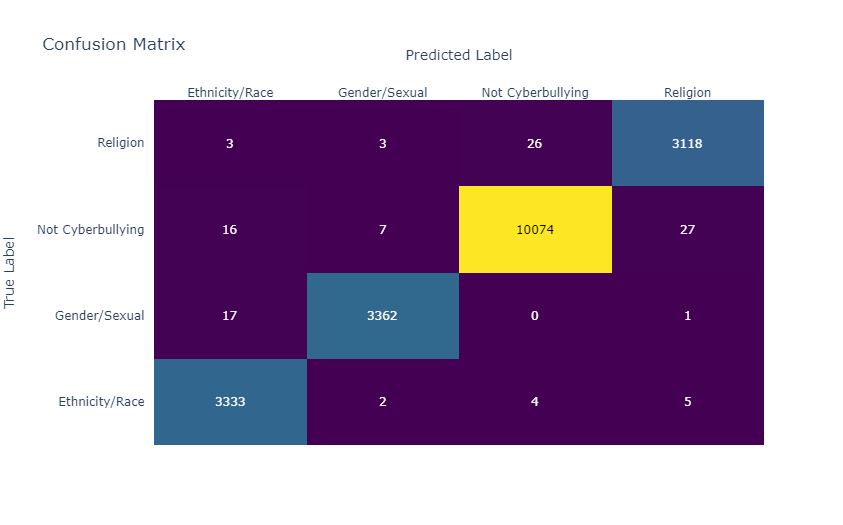

In [2]:
example_text = ['I can do this all day , your religion is useless nigga']
encodings = tokenizer(example_text, truncation=True, padding=True)
example_encodings = {"input_ids": encodings['input_ids'], "attention_mask": encodings['attention_mask']} # Replace 0 with an appropriate label or dummy label
example_dataset = CustomDataset(example_encodings)
predictions = trainer.predict(example_dataset)
predicted_label_idx = np.argmax(predictions.predictions, axis=-1)[0]
label_mapping = {'ethnicity/race': 0, 'not_cyberbullying': 2, 'religion': 3, 'gender/sexual': 1}
predicted_label = [key for key, value in label_mapping.items() if value == predicted_label_idx]

print(f"Predicted label: {predicted_label}")

NameError: name 'tokenizer' is not defined

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

# Define your class labels
class_labels = ['Ethnicity/Race', 'Gender/Sexual', 'Not Cyberbullying', 'Religion']

# Load the model and tokenizer
model_path = "./final_model"  # Path where your model is saved
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")  # Use the same tokenizer as during training

# Set the model to evaluation mode
model.eval()

# Function to make predictions
def predict_cyberbullying(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits
        
    # Get the predicted class
    predicted_class_id = torch.argmax(predictions, dim=1).item()
    predicted_label = class_labels[predicted_class_id]
    
    # Get prediction probabilities
    probs = torch.nn.functional.softmax(predictions, dim=1)
    confidence = probs[0][predicted_class_id].item()
    
    return {
        "label": predicted_label,
        "confidence": confidence,
        "probabilities": {class_labels[i]: probs[0][i].item() for i in range(len(class_labels))}
    }

# Example usage
test_texts = [
    "I hate people from your country",
    "You're stupid because you're a woman",
    "Let's meet tomorrow at the park",
    "Your religion is evil and you should be ashamed",
    "your religion is bad"
]

for text in test_texts:
    result = predict_cyberbullying(text)
    print(f"Text: {text}")
    print(f"Prediction: {result['label']} (Confidence: {result['confidence']:.2%})")
    print()

Text: I hate people from your country
Prediction: Not Cyberbullying (Confidence: 99.93%)

Text: You're stupid because you're a woman
Prediction: Not Cyberbullying (Confidence: 99.85%)

Text: Let's meet tomorrow at the park
Prediction: Not Cyberbullying (Confidence: 99.99%)

Text: Your religion is evil and you should be ashamed
Prediction: Religion (Confidence: 100.00%)

Text: your religion is bad
Prediction: Religion (Confidence: 99.99%)

